In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

First we contstruct the MDP

In [19]:
class MDP():

    def __init__(self, r_list, Lambda):
        self.LAMBDA = Lambda
        self.R = r_list
        self.N = len(r_list)
        self.state = [0]*self.N
    
    def reset(self):
        self.state = [0]*self.N
        return self.state

    def action(self, action):
        cost = 0

        #The new job is routed according to the probabilities of the action
        routed_q = random.choices([i for i in range(self.N)], weights = action)[0]
        self.state[routed_q] += 1

        for i in range(self.N):

            #The queues sizes are updated
            size = self.state[i]
            if size != 0:
                served_jobs = random.choices([k for k in range(size + 1)], weights=[self.__q(i,j) for j in range(size + 1)])[0]
                self.state[i] -= served_jobs
                
                #the size of the queue is added to the cost
                cost += served_jobs - size

        #cost+1 in order to account for the newly routed job
        return (self.state, cost)

    def state(self):
        return self.state

    def __q(self, i, j): #the probability that j jobs are served at Queue i
        if j == self.state[i]:
            return((self.R[i] / (self.R[i] + self.LAMBDA))**j)
        else:
           return(self.LAMBDA * (self.R[i]**j) / (self.R[i] + self.LAMBDA)**j)

Action space

In [3]:
#recursive function for the generation of the action space
def rec(action, d, N, sum, len):
    if len > N:
        return []
    elif len == N:
        if sum == d:
            return [action]
        return []
    elif sum == d:
        return rec(action + [0], d, N, sum, len+1)
    ans = []
    i = 0
    while sum+i <= d:
        ans += rec(action+[i/d], d, N, sum+i, len+1)
        i += 1
    return ans

def action_space(d, N):
    return rec([], d, N, 0, 0)


State space

In [4]:
def rec_s(state, N, len, max_queue_length):
    if len > N:
        return []
    elif len == N:
        return [state]
    ans = []
    i = 0
    while i <= max_queue_length:
        ans += rec_s(state+[i], N, len+1, max_queue_length)
        i += 1
    return ans

def state_space(N, max):
    return rec_s([], N, 0, max)

The Q-learning algorithm:

In [62]:
# ns = 30000 #number of steps per episode
# ne = 3000 #number of episodes
# e = 10 #probability taking a random action
# delta = 0.5 #discount factor
# l_rate = 0.6 #learning rate

# r_list = [0.5, 0.5] #list of the server rates
# l = 0.5 #lambda

# d = 10
# max_queue_length = 50

def qber(ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length):

    #########
    title = 'ns: '+ str(ns)+ ' ne: '+ str(ne)+ ' ε: '+ str(e)+ ' δ: '+ str(delta)+ ' l rate:', l_rate, ' r list: '+ str(r_list)+ ' λ: '+ str(l)+ ' d:'+ str(d)+ ' max: '+ str(max_queue_length)
    plt.title(title)
    #########

    N = len(r_list)
    #generation of the action space
    action_s = action_space(d, N)

    #generation of the states
    state_s = state_space(N, max_queue_length)

    #generation of the q-table
    act_len = len(action_s)
    q = np.zeros((len(state_s), act_len))

    mdp = MDP(r_list, l)

    class QueueError(Exception):
        pass

    #########
    qualities = [[] for action in action_s]
    #########

    for episode in range(ne):
        #print((episode+1)/ne, 'eps.:', e, action_s[np.argmax(q[0])])

        #########
        if e > 1:
            cambio1 = episode
        if e > 0:
            cambio0 = episode
        for act in action_s:
            act_number = action_s.index(act)
            qualities[act_number].append(q[0][act_number])
        #########
        
        try:
            #get initial state
            state = mdp.reset()
            #check for queue length
            if state in state_s:
                state_number = state_s.index(state)
            else:
                raise QueueError

            for step in range(ns):
                #take minimun quality action
                if random.uniform(0,1) > e:
                    action_number = np.argmax(q[state_s.index(state)])
                    action = action_s[action_number]
                #take random action
                else:
                    action = random.choices(action_s)[0]
                    action_number = action_s.index(action)

                #take action, get new_state and reward
                (new_state, cost) = mdp.action(action)

                #check for queue lenth
                if new_state in state_s:
                    new_state_number = state_s.index(new_state)
                else:
                    raise QueueError
                
                #update q-table
                q[state_number, action_number] = q[state_number, action_number] + l_rate*(cost + delta*np.max(q[new_state_number, :]) - q[state_number, action_number])

                state = new_state
                state_number = new_state_number
                e -= 0.0001 
        except QueueError:
            pass

    #########
    for act in action_s:
        act_number = action_s.index(act)
        plt.plot(qualities[act_number], label = act)
    plt.axvline(x=cambio0)
    plt.axvline(x=cambio1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    #########

1 / 10 = 0.1


KeyboardInterrupt: 

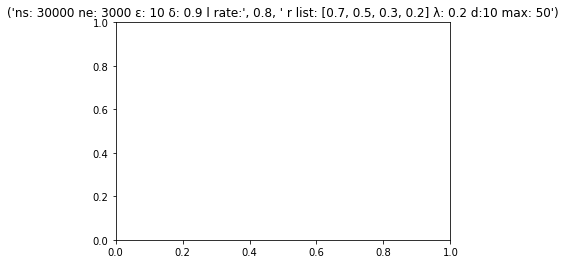

In [65]:
tests = [
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.7, 0.5, 0.3, 0.2], #list of the server rates
        0.2, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.5, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        300, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.5, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        3000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.5, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.5, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.2, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.1, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.7, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.7, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    )
]

count = 1
T = len(tests)
for ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length in tests:
    print(count, '/', T, '=', count/T)
    qber(ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length)
    count += 1

In [38]:
# with np.printoptions(threshold=np.inf):
#     print(q)

[[ -3.20845984  -3.23701132  -3.21823602  -1.28910692  -3.20770882
   -3.2169968   -3.20896213  -3.21976653  -3.25572007  -3.26539334
   -3.20242853]
 [ -5.18042789  -5.01347272  -5.02488831  -5.01414077  -5.02310181
   -5.03718402  -5.09207629  -5.01231204  -5.05771577  -5.00731371
   -1.84042064]
 [ -6.93388196  -6.82250472  -6.78618566  -6.86981434  -6.8067135
   -6.85145296  -6.78558149  -6.79167819  -6.78783854  -4.84114549
   -6.91658897]
 [ -8.74241105  -8.72986093  -8.68619952  -8.71858126  -7.77474711
   -8.70763955  -8.69424096  -8.87924215  -8.72873837  -8.7224144
   -8.68382097]
 [-10.63225298 -10.70466015 -10.6742678  -10.57689561 -10.81612495
  -10.70895564 -10.57824723 -10.61469885 -10.82202671 -10.60524159
   -7.8348725 ]
 [-12.49783558 -12.40469496 -12.51134631 -12.62873676 -12.67386925
  -12.65625832 -12.5213035  -12.52687627 -12.46977417  -9.02655578
  -12.39428549]
 [-14.56979387 -14.61844965 -14.36515349 -14.28619355 -14.34699133
  -14.37152065 -14.30288515 -10.706